In [246]:
import os
import pandas as pd
import numpy as np
import mavenn 
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric import nn as nnt
from torch_geometric.data import Data

## Loading the CA CA Coordinate of 2j52

CA CA distance of 7. $\overset{\circ}{\mathbb{A}}$ is used for building the neighbor graph.

In [316]:
crd_file = 'pdb/2j52_ca.crd'
neighbor_distance = 7.


df = pd.read_csv(crd_file, index_col=None, sep='\t') 
xyz = df.values[1:]
xi, yi = np.where(np.sqrt(np.sum(np.square(xyz[np.newaxis, ...] - xyz[:, np.newaxis, :]), axis=-1)) < neighbor_distance)

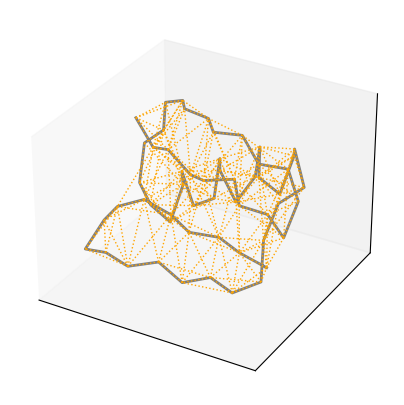

In [319]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.plot(xyz[:, 0], xyz[:, 1], xyz[:, 2],  linewidth=2, color='gray')

for x_i, y_i in zip(xi, yi):
    if x_i < y_i:
        ax.plot(xyz[[x_i, y_i], 0], xyz[[x_i, y_i], 1], xyz[[x_i, y_i], 2], linestyle='dotted', color='orange', linewidth=1)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

## Loading Nisthal Dataset

In [25]:
data_df = mavenn.load_example_dataset('nisthal')

### Auxiliary functions

In [36]:
def encode_amino(aa: str):
    all_aminos = "ACDEFGHIKLMNPQRSTVWY"
    index = all_aminos.index(aa)
    code = np.zeros(len(all_aminos) + 1, dtype=float)
    code[index] = 1.
    return code


def encode_protein(seq: str):
    return np.array(list(map(lambda x: encode_amino(x), list(seq.upper()))))

In [50]:
def get_data_instance(index: int):
    return Data(x=torch.from_numpy(encode_protein(data_df.x[index])).float(), 
                edge_index=torch.from_numpy(np.array([xi, yi]).T).long().t().contiguous(),
                y=torch.tensor([data_df.y[index]]).float())

In [51]:
data_list = [get_data_instance(i) for i in range(data_df.shape[0])]

In [169]:
train_data = int(len(data_list) * 0.8)
test_data = len(data_list) - train_data

In [170]:
np.random.shuffle(data_list)

In [228]:
from torch_geometric.loader import DataListLoader

train_loader = DataListLoader(data_list[:train_data], batch_size=64, shuffle=True)
test_loader = DataListLoader(data_list[train_data:], batch_size=64, shuffle=False)

## Custom Graph Convolution Model

In [172]:
class CustomGraphEmbedding(nn.Module):
    def __init__(self, 
                 depth: int = 3,
                 embedding_dim: int = 16,
                 conv_type: str = 'gat',
                ):
        super(CustomGraphEmbedding, self).__init__()
        self._mlp = nn.Linear(21, embedding_dim)
        if conv_type == 'gat':
            self._conv1 = nnt.GATConv(embedding_dim, embedding_dim, heads=2, concat=False, dropout=0.5)
            self._conv2 = nnt.GATConv(embedding_dim, embedding_dim, heads=2, concat=False, dropout=0.5)
            self._conv3 = nnt.GATConv(embedding_dim, embedding_dim, heads=2, concat=False, dropout=0.5)
        else:
            self._conv1 = nnt.SAGEConv(embedding_dim, embedding_dim)
            self._conv2 = nnt.SAGEConv(embedding_dim, embedding_dim)
            self._conv3 = nnt.SAGEConv(embedding_dim, embedding_dim)
        self._reg = nn.Linear(embedding_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self._mlp(x)
        x = self._conv1(x, edge_index)
        x = F.relu(x)
        x = self._conv2(x, edge_index)
        x = F.relu(x)
        x = self._conv3(x, edge_index)
        x = F.relu(x)
        y = torch.mean(x, dim=0, keepdim=True)
        return self._reg(y), x


In [173]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Graph Neural Network Training step

In [236]:
def train_model(epoch: int, 
                model: nn.Module, 
                optimizer_c: torch.optim.Optimizer):
    model.train()
    error = 0
    for batch in train_loader:
        optimizer_c.zero_grad()
        ye_, y_ = list(), list()
        for data in batch:
            data = data.to(device)
            ye, _ = model(data)
            ye_.append(ye)
            y_.append(data.y)
        loss = torch.sum(torch.square(torch.squeeze(torch.concat(ye_, dim=0)) - torch.squeeze(torch.concat(y_, dim=0))))
        loss.backward()
        optimizer_c.step()
        error += loss.item()
    batch_mse = error / len(data_list)
    if epoch % 5 == 0:
        print(f"RMSE @{epoch:4d}: {batch_mse:.5f}")

### Plotting Utility Function

In [221]:
def get_model_scores(model):
    model.eval()
    y_true = list()
    y_pred = list()
    embedding = list()
    with torch.no_grad():
        for batch in test_loader:
            for data in batch:
                data = data.to(device)
                ye, emb = model(data)
                y_true.append(np.squeeze(data.y.detach().cpu().numpy()))
                y_pred.append(np.squeeze(ye.detach().cpu().numpy()))
                embedding.append(emb.detach().cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.stack(embedding, axis=0)
                

In [304]:
def plot_scores(model,
               figure_size = (10, 10),
               ):
    y_true, y_pred, _ = get_model_scores(model)
    index_ = np.argsort(y_true)
    poly = np.polyfit(y_true[index_], y_pred[index_], 1)
    x = np.linspace(np.min(y_true), np.max(y_true), 51)
    y = np.poly1d(poly)(x)
   
    fig, ax = plt.subplots(1, 1, figsize=figure_size)
    ax.scatter(y_true, y_pred, marker='o', color='orange')
    ax.plot(x, y, color='red', linewidth=1.5, linestyle='dotted')
    ax.set_xlabel('True $\\Delta\\Delta G$')
    ax.set_ylabel('Predicted $\\Delta\\Delta G$')
    plt.show()

In [243]:
model_path = 'models/model_sage.pl'

if os.path.exists(model_path):
    model_sage = torch.load(model_path, weights_only=False)
else:
    model_sage = CustomGraphEmbedding(conv_type='sage')
model_sage = model_sage.to(device)

In [244]:
optimizer_sage = torch.optim.Adam(model_sage.parameters(), lr=0.001)

In [245]:
for i in range(1, 101):
    train_model(i, model_sage, optimizer_sage)

RMSE @   5: 0.18106
RMSE @  10: 0.18036
RMSE @  15: 0.18162
RMSE @  20: 0.18110
RMSE @  25: 0.17900
RMSE @  30: 0.17944
RMSE @  35: 0.18009
RMSE @  40: 0.17939
RMSE @  45: 0.17727
RMSE @  50: 0.17971
RMSE @  55: 0.17831
RMSE @  60: 0.17709
RMSE @  65: 0.17828
RMSE @  70: 0.17552
RMSE @  75: 0.17926
RMSE @  80: 0.17503
RMSE @  85: 0.17730
RMSE @  90: 0.17444
RMSE @  95: 0.17486
RMSE @ 100: 0.17435


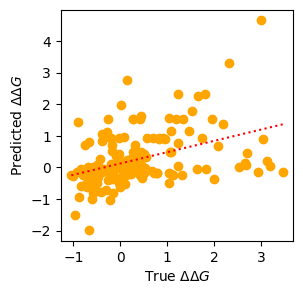

In [305]:
plot_scores(model_sage, figure_size=(3, 3))

In [241]:
torch.save(model_sage.to('cpu'), 'models/model_sage.pl')

In [331]:
from sklearn.decomposition import PCA 

In [341]:
def scale_0_1(x_):
    return (x_ - np.min(x_)) / (np.max(x_) - np.min(x_))


def draw_sequence(data_index: int = 0,
                  pca_dim: int = 1,
                 ):
    emb = get_model_scores(model_sage)[-1]
    pca = PCA(n_components=pca_dim, random_state=42)
    seq_xy = pca.fit_transform(emb[data_index])
    cmap = plt.get_cmap('hot')

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=scale_0_1(seq_xy[:, 0]), s=50, marker='o', cmap=cmap)
    ax.plot(xyz[:, 0], xyz[:, 1], xyz[:, 2],  linewidth=2, color='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    plt.show()

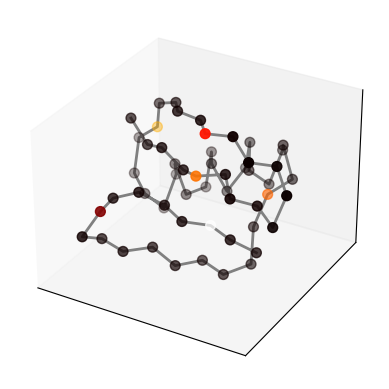

In [343]:
draw_sequence(4)